In [24]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.spatial.distance import cdist
import seaborn as sns
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
'''
Load data 
'''

mouse = pd.read_pickle('/cellar/users/mdow/Projects/HCC/RNA_analysis/mouse_rnaseq_hom.pkl')

human = pd.read_pickle('/cellar/users/mdow/Projects/HCC/RNA_analysis/human_rnaseq_hom.pkl')

print mouse.shape, human.shape

(17046, 56) (17046, 183)


In [3]:
'''
Load iCluster information
Need: patient ID and cluster 

'''
iclust_raw = pd.read_excel('/cellar/users/mdow/Projects/HCC/RNA_analysis/iCluster/mmc1.xlsx',skiprows=3)
iclust_raw['patient_id'] = iclust_raw.Barcode.str.split('-').str[2].str.lower()

m1=iclust_raw.columns.str.contains('patient_id')
m2=iclust_raw.columns.str.contains('iCluster')
iclust = iclust_raw.iloc[:,(m1|m2)].dropna()

print iclust.shape

iclust.columns = ['iCluster','patient_id']

iclust['iCluster'] = iclust.iCluster.str.split(':').str[1]

'''
Select only the iCluster patients 
'''
allPatients = human.columns.tolist()
tmp = [i in iclust.patient_id.tolist() for i in allPatients]

iclustDf = human.iloc[:,tmp]

print iclustDf.shape

(183, 2)
(17046, 183)


In [4]:

def corr(df1,df2):
    myM=cdist(df1.T,df2.T,'correlation')
    return 1-pd.DataFrame(data=myM,index=df1.columns,columns=df2.columns)

'''
log transform 
'''
logMouse,logHuman=np.log2(mouse+1),np.log2(human+1)


'''
Combine mouse and human information
'''
mouseInfo = pd.DataFrame(logMouse.columns.tolist())
mouseInfo.columns = ['clust','Sample']
iclust.columns = ['clust','Sample']

allSampleInfo = pd.concat([iclust,mouseInfo])
allSampleInfo.index = allSampleInfo.Sample

myDict = allSampleInfo.to_dict()['clust']

'''
Calculate z-score of the mouse and human data
Try to see if we can cluster mouse and human after z-score
Doesn't seem like it? #!!!
'''

#(inZDf-inZDf.mean(axis=0))/inZDf.std(axis=0)
def get_z(inZDf):
    tmp = stats.zscore(inZDf)
    outZDf = pd.DataFrame(tmp)
    outZDf.columns = inZDf.columns
    outZDf.index = inZDf.index
    return outZDf

mouseZ=get_z(logMouse)
humanZ=get_z(logHuman)


In [18]:
'''
Calculate MAD for mouse and human
'''
humanMad=logHuman.std(axis=1)
mouseMad=logMouse.std(axis=1)

'''
Calculate correlation with MAD
'''

madThres = 0.5 #!!!
madSRaw=logHuman.std(axis=1)
madS=madSRaw[madSRaw > madThres]

pd.DataFrame(madS.index).to_csv('genes.csv')

in_Corr_MouseDf=logMouse.loc[madS.index]#.iloc[:,:1]
in_Corr_HumanDf=logHuman.loc[madS.index]#.iloc[:,:1]

# z-score before calculating corr?
corrDf=corr(df1=in_Corr_HumanDf,df2=in_Corr_MouseDf)

distToAllPatients=corrDf.mean(axis=0)

print corrDf.shape

print in_Corr_HumanDf.shape, in_Corr_MouseDf.shape

(183, 56)
(12713, 183) (12713, 56)


In [29]:
logMouse.head()

strain          TAK1                                                  \
sample  AT136_T1_S23 AT136_T2_S24 AT136_T3_S25 AT388_S26 AT66_T1_S19   
hgnc                                                                   
a1cf        4.944777     5.183994     4.505948  2.932207    5.627406   
a2m         0.053264     0.012936     0.085589  0.000000    0.013747   
a3galt2     0.031087     0.000000     0.000000  0.027910    0.000000   
a4galt      1.607406     0.591475     0.982240  0.398781    1.757987   
a4gnt       0.925985     0.190624     1.870227  1.142021    0.047444   

strain                                                   STAM    ...     \
sample  AT66_T2_S20 AT66_T3_S21  AT81_S22 AT863_S27 J750T2_S1    ...      
hgnc                                                             ...      
a1cf       4.870937    4.800851  4.884029  4.488666  4.821792    ...      
a2m        0.085234    0.021960  0.013257  0.061020  0.552981    ...      
a3galt2    0.034698    0.000000  0.018542  0.000000  0.000000    ...      
a4galt     3.305258    0.768020  0.466482  1.088329  2.894647    ...      
a4gnt      0.085342    1.111626  0.633109  1.590027  1.274912    ...      

strain        DEN                                                              \
sample    T62_S15   T67_S16   T71_S17   T79_S16    T7_S11   T82_S17   T86_S18   
hgnc                                                                            
a1cf     4.615295  5.403218  5.439382  5.195671  5.035593  5.235712  5.286129   
a2m      0.305309  0.303250  1.604226  0.047006  0.488644  0.104045  0.249394   
a3galt2  0.000000  0.022320  0.058623  0.000000  0.024450  0.000000  0.000000   
a4galt   0.440672  0.296386  0.518898  0.460151  0.868618  0.577401  0.903349   
a4gnt    0.219719  0.350594  0.191515  0.000000  0.463839  0.000000  0.107675   

strain                                 
sample    T89_S18   T92_S19   T93_S20  
hgnc                                   
a1cf     4.837794  4.665486  4.869630  
a2m      0.180551  0.140358  0.536299  
a3galt2  0.017344  0.000000  0.050608  
a4galt   0.789368  0.344876  0.517623  
a4gnt    0.000000  0.050319  0.101230  

[5 rows x 56 columns]

In [8]:
#inZdf=corrDf.loc[subSampledPatientS.index].sort_index(axis=1).T
inZdf=corrDf.T
#outZDf=(inZdf-inZdf.mean(axis=0))/inZdf.std(axis=0)
outZDf=get_z(inZdf)

# Sort the human samples based on iCluster 
patientSort = iclust.sort_values(['clust'])

outZDf_srt = outZDf.loc[:,patientSort.Sample]


'''
Set colors
'''
clustColor = sns.color_palette("deep", 10)
patColor = sns.color_palette("Set2", 10)

cluster_strains = outZDf_srt.index.get_level_values(level='strain')

inColorVals=cluster_strains
factors=inColorVals.unique()
strainToColor=pd.Series(index=factors, data=clustColor[0:4])
row_colors=strainToColor.loc[inColorVals].values


patient_data = pd.Series(outZDf_srt.columns).map(myDict)
factors=patient_data.unique()
patientToColor=pd.Series(index=factors, data=patColor[3:6])
col_colors=patientToColor.loc[patient_data].values


oldToColors = pd.Series(index=[True,False], data=clustColor[0:2])

#old_den = ['T62','T38','T58','T34','T42','T61', 'T79', 'T86','T82']
old_den = ['T62_S15','T38_S11','T58_S13','T34_S10','T42_S12',
           'T61_S14','T79_S16','T86_S18','T82_S17']

In [9]:
myMouse = outZDf_srt.index.get_level_values('strain').unique()

0.5 (12713, 56) (12713, 183)


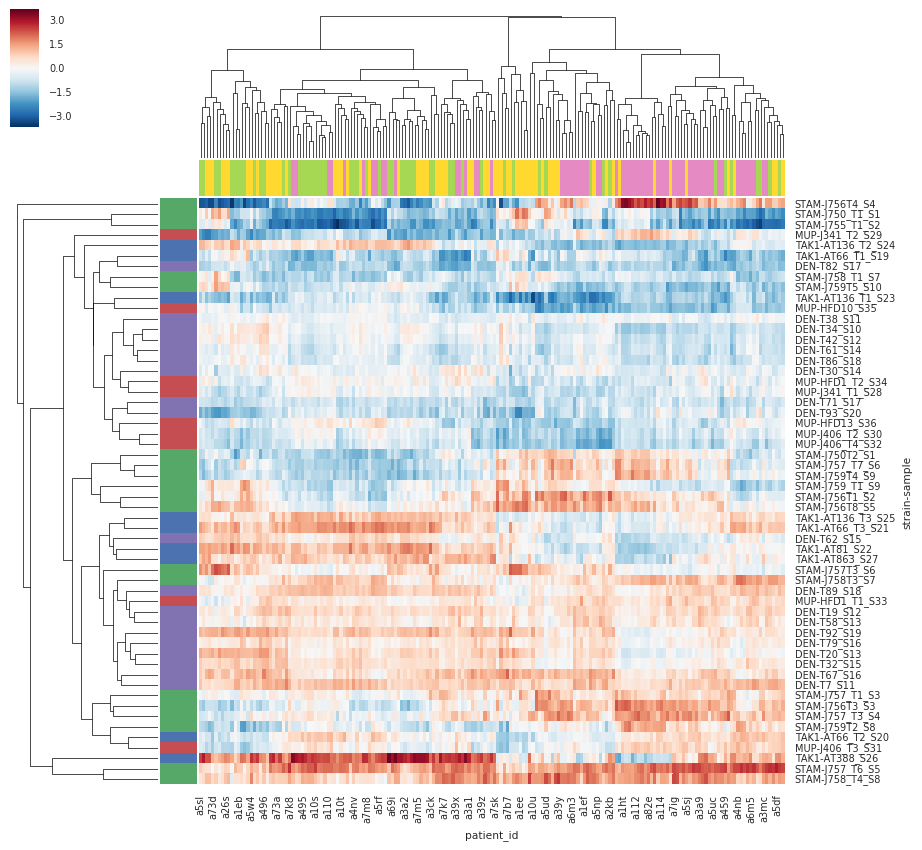

In [26]:
sns.set(font_scale=0.7)
print madThres, in_Corr_MouseDf.shape, in_Corr_HumanDf.shape

ax = sns.clustermap(outZDf_srt,row_colors=row_colors, col_colors=col_colors,cmap='RdBu_r')

ax.savefig("correlation_heatmap.png")

## Set specific gene set?

In [ ]:
#exp_prolif_hum = in_Corr_HumanDf[in_Corr_HumanDf.index.isin(prolif_cnt.hgnc.tolist())]
#exp_prolif_mouse = in_Corr_MouseDf[in_Corr_MouseDf.index.isin(prolif_cnt.hgnc.tolist())]

In [28]:
#ax = sns.clustermap(in_Corr_HumanDf,row_colors=row_colors, col_colors=col_colors,cmap='RdBu_r')

(168, 4) (10248, 5)


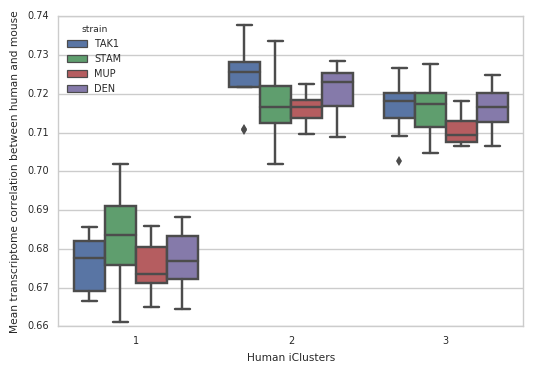

In [23]:
corrDfS = corrDf.T.stack().reset_index(name='Corr')

corrDfS['iClust'] = corrDfS.patient_id.map(myDict)

# Calculate separate distance for the iClusters
meanCorr = corrDfS.groupby(['strain','sample','iClust']).Corr.mean().reset_index(name='meanCorr')

print meanCorr.shape, corrDfS.shape

'''
Plot the raw correlation
'''
sns.set_style('whitegrid')
ax2 = sns.boxplot(data=meanCorr,x='iClust',y='meanCorr',hue='strain',hue_order=['TAK1','STAM','MUP','DEN'],)
ax2.set_xlabel('Human iClusters')
ax2.set_ylabel('Mean transcriptome correlation between human and mouse')

ax2.figure.savefig("correlation_boxplot.png")

### ====== Select method

In [22]:
# default use MAD to select genes
# Can also do specific set, e.g. proliferative gene set

### ====================== chunk

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.spatial.distance import cdist
import seaborn as sns
import os
from argparse import ArgumentParser
import matplotlib.pyplot as plt


'''
Calculate correlation
'''
def corr(df1,df2):
	    myM=cdist(df1.T,df2.T,'correlation')
	    return 1-pd.DataFrame(data=myM,index=df1.columns,columns=df2.columns)
'''
Calculate z-score of the mouse and human data
'''
#(inZDf-inZDf.mean(axis=0))/inZDf.std(axis=0)
def get_z(inZDf):
    tmp = stats.zscore(inZDf)
    outZDf = pd.DataFrame(tmp)
    outZDf.columns = inZDf.columns
    outZDf.index = inZDf.index
    return outZDf

'''
Calculate correlation with MAD
'''

def mad_genes():
	#madThres = 0.5 #!!!
	madSRaw=logHuman.std(axis=1)
	madS=madSRaw[madSRaw > madThres]

	pd.DataFrame(madS.index).to_csv('genes.csv')

def main(madThres, geneSet):
	    
	'''
	Load data 
	'''

	mouse = pd.read_pickle('mouse_rnaseq_hom.pkl')
	human = pd.read_pickle('human_rnaseq_hom.pkl')

	print 'Number of starting genes-','in mouse:',mouse.shape[0],'in human:', human.shape[0]
	print 'Number of mouse samples',mouse.shape[1],', human patients', human.shape[1]

	'''
	Load iCluster information
	Need: patient ID and cluster 

	'''
	iclust_raw = pd.read_excel('mmc1.xlsx',skiprows=3)
	iclust_raw['patient_id'] = iclust_raw.Barcode.str.split('-').str[2].str.lower()

	m1=iclust_raw.columns.str.contains('patient_id')
	m2=iclust_raw.columns.str.contains('iCluster')
	iclust = iclust_raw.iloc[:,(m1|m2)].dropna()

	print 'Number of patients with iCluster definition:',iclust.shape[0]

	iclust.columns = ['iCluster','patient_id']

	iclust['iCluster'] = iclust.iCluster.str.split(':').str[1]

	'''
	Select only the iCluster patients 
	'''
	allPatients = human.columns.tolist()
	tmp = [i in iclust.patient_id.tolist() for i in allPatients]

	iclustDf = human.iloc[:,tmp]

	#print iclustDf.shape
	
	'''
	log transform 
	'''
	logMouse,logHuman=np.log2(mouse+1),np.log2(human+1)


	'''
	Combine mouse and human information
	'''
	mouseInfo = pd.DataFrame(logMouse.columns.tolist())
	mouseInfo.columns = ['clust','Sample']
	iclust.columns = ['clust','Sample']

	allSampleInfo = pd.concat([iclust,mouseInfo])
	allSampleInfo.index = allSampleInfo.Sample

	myDict = allSampleInfo.to_dict()['clust']

	'''
	Calculate z-score for mouse and human
	'''

	mouseZ=get_z(logMouse)
	humanZ=get_z(logHuman)


	'''
	Calculate MAD for mouse and human
	'''
	humanMad=logHuman.std(axis=1)
	mouseMad=logMouse.std(axis=1)

	'''
	Calculate correlation with MAD
	'''
	if geneSet != '':
		geneDf = pd.read_csv(geneSet,header=None)
		geneDf.columns = ['Gene']
		print geneDf.shape
		tmp = pd.Series([g.lower() for g in geneDf.Gene])
		myGenes = tmp[tmp.isin(logMouse.index)]
	else:
		#madThres = 0.5 #!!!
		madSRaw=logHuman.std(axis=1)
		madS=madSRaw[madSRaw > madThres]
		myGenes = madS.index
		pd.DataFrame(madS.index).to_csv('genes.csv',index=False)

	#print myGenes
	in_Corr_MouseDf=logMouse.loc[myGenes]
	in_Corr_HumanDf=logHuman.loc[myGenes]

	# z-score before calculating corr?
	corrDf=corr(df1=in_Corr_HumanDf,df2=in_Corr_MouseDf)

	distToAllPatients=corrDf.mean(axis=0)

	#print corrDf.shape
	print 'MAD threshold:', madThres
	print 'Number of genes selected:',in_Corr_HumanDf.shape[0]#, in_Corr_MouseDf.shape

	#inZdf=corrDf.loc[subSampledPatientS.index].sort_index(axis=1).T
	inZdf=corrDf.T
	#outZDf=(inZdf-inZdf.mean(axis=0))/inZdf.std(axis=0)
	outZDf=get_z(inZdf)

	# Sort the human samples based on iCluster 
	patientSort = iclust.sort_values(['clust'])

	outZDf_srt = outZDf.loc[:,patientSort.Sample]


	'''
	Set colors
	'''
	clustColor = sns.color_palette("deep", 10)
	patColor = sns.color_palette("Set2", 10)

	cluster_strains = outZDf_srt.index.get_level_values(level='strain')

	inColorVals=cluster_strains
	factors=inColorVals.unique()
	strainToColor=pd.Series(index=factors, data=clustColor[0:4])
	row_colors=strainToColor.loc[inColorVals].values


	patient_data = pd.Series(outZDf_srt.columns).map(myDict)
	factors=patient_data.unique()
	patientToColor=pd.Series(index=factors, data=patColor[3:6])
	col_colors=patientToColor.loc[patient_data].values


	oldToColors = pd.Series(index=[True,False], data=clustColor[0:2])

	#old_den = ['T62','T38','T58','T34','T42','T61', 'T79', 'T86','T82']
	old_den = ['T62_S15','T38_S11','T58_S13','T34_S10','T42_S12',
	           'T61_S14','T79_S16','T86_S18','T82_S17']

	myMouse = outZDf_srt.index.get_level_values('strain').unique()

	sns.set(font_scale=0.7)
	#print madThres, in_Corr_MouseDf.shape, in_Corr_HumanDf.shape

	ax = sns.clustermap(outZDf_srt,row_colors=row_colors, col_colors=col_colors,cmap='RdBu_r')
	plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
	plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
	ax.savefig("correlation_heatmap.png")

	corrDfS = corrDf.T.stack().reset_index(name='Corr')

	corrDfS['iClust'] = corrDfS.patient_id.map(myDict)

	# Calculate separate distance for the iClusters
	meanCorr = corrDfS.groupby(['strain','sample','iClust']).Corr.mean().reset_index(name='meanCorr')

	#print meanCorr.shape, corrDfS.shape

	'''
	Plot the raw correlation
	'''
	plt.figure()
	sns.set_style('whitegrid')
	ax2 = sns.boxplot(data=meanCorr,x='iClust',y='meanCorr',hue='strain',hue_order=['TAK1','STAM','MUP','DEN'],)
	ax2.set_xlabel('Human iClusters')
	ax2.set_ylabel('Mean transcriptome correlation between human and mouse')

	ax2.figure.savefig("correlation_boxplot.png")

if __name__ == "__main__":

    parser = ArgumentParser()
    parser.add_argument('--madThres', dest='madThres', type=int, default=0.5, required=False, help='Choose MAD for the human gene cutoff')
    parser.add_argument('--geneSet', dest='geneSet', type=str, default='', required=False, help='Calculaate correlation by specific gene set')
    
    args = parser.parse_args()

    main(args.madThres,args.geneSet)